## CAPSTONE PROJECT - CLASSIFICATION

In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### IMPORT PACKAGES

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

#### READ DATASET

In [47]:
path = '/content/gdrive/MyDrive/NarasioData/Junior Data Scientist/Meet 5/4. Classification - Credit Card Lead/'
df_train = pd.read_csv(path + 'train.csv')
df_train['jenis'] = 'train'

df_test = pd.read_csv(path + 'test.csv')
df_test['jenis'] = 'test'

df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,jenis
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.0,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.0,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.0,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.0,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.0,train


#### PROBLEM STATEMENT

<p>Happy Customer Bank adalah bank swasta menengah yang menangani semua jenis produk perbankan, seperti tabungan, giro, produk investasi, serta produk kredit, di antara penawaran lainnya. Bank ini juga melakukan cross-selling produk kepada nasabah yang sudah ada dan untuk melakukannya mereka menggunakan berbagai jenis komunikasi seperti telecalling, e-mail, rekomendasi tentang net banking, mobile banking, dan lain-lain. Dalam hal ini, Happy Customer Bank ingin melakukan cross-selling kartu kreditnya kepada nasabah yang sudah ada. Bank telah mengidentifikasi satu set pelanggan yang memenuhi syarat untuk mengambil kartu kredit ini. Sekarang, bank meminta bantuan Anda dalam mengidentifikasi pelanggan yang dapat menunjukkan ketertarikan yang lebih tinggi terhadap kartu kredit yang direkomendasikan.</p>

#### EDA

In [48]:
#melihat info dataframe dan ukuran dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351037 entries, 0 to 351036
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   351037 non-null  object 
 1   Gender               351037 non-null  object 
 2   Age                  351037 non-null  int64  
 3   Region_Code          351037 non-null  object 
 4   Occupation           351037 non-null  object 
 5   Channel_Code         351037 non-null  object 
 6   Vintage              351037 non-null  int64  
 7   Credit_Product       309190 non-null  object 
 8   Avg_Account_Balance  351037 non-null  int64  
 9   Is_Active            351037 non-null  object 
 10  Is_Lead              245725 non-null  float64
 11  jenis                351037 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 32.1+ MB


In [49]:
df.nunique()

ID                     351037
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    162137
Is_Active                   2
Is_Lead                     2
jenis                       2
dtype: int64

In [50]:
df.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product          41847
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
jenis                       0
dtype: int64

In [51]:
df['Credit_Product'] = df['Credit_Product'].fillna('NA')

In [52]:
df.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product              0
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
jenis                       0
dtype: int64

#### VISUALIZATION

<h4>Univariate Analysis</h4>

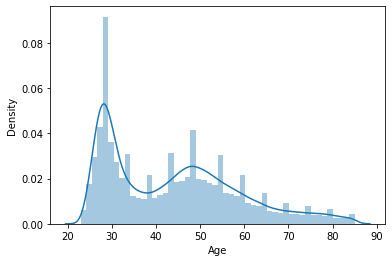

In [53]:
sns.distplot(df['Age'])
plt.show()

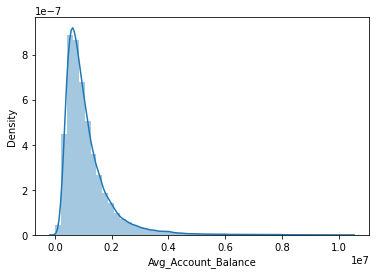

In [54]:
sns.distplot(df['Avg_Account_Balance'])
plt.show()

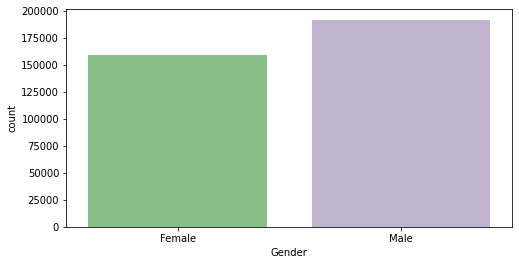

In [55]:
plt.figure(figsize=(8,4))
sns.countplot(df['Gender'], palette='Accent')
plt.show()

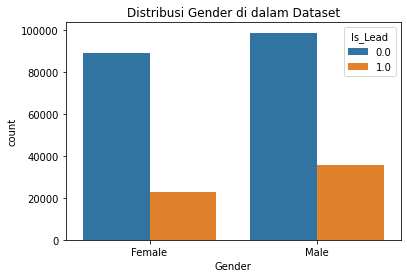

In [56]:
ax = sns.countplot(x=df['Gender'], hue=df.Is_Lead)
ax.set_title('Distribusi Gender di dalam Dataset')
plt.show()

0.0    187437
1.0     58288
Name: Is_Lead, dtype: int64


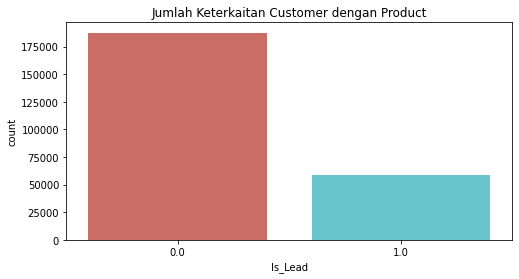

In [57]:
target = 'Is_Lead'
plt.figure(figsize=(8,4))
ax = sns.countplot(df[target], palette='hls')
ax.set_title('Jumlah Keterkaitan Customer dengan Product')
print(df[target].value_counts())

<h4>Bivariate Analysis</h4>

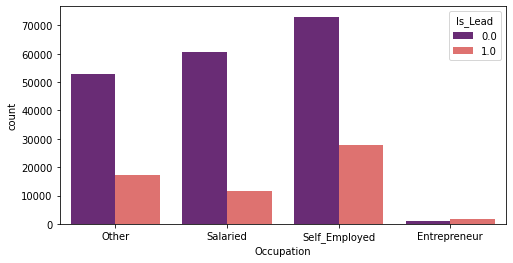

In [58]:
#Entrepreneur = 0
#Other = 1
#Salaried = 2
#Self_Employed = 3
plt.figure(figsize=(8,4))
sns.countplot(x='Occupation', hue='Is_Lead', data=df, palette='magma')
plt.show()

In [59]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,jenis
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.0,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.0,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.0,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.0,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.0,train


<Figure size 576x288 with 0 Axes>

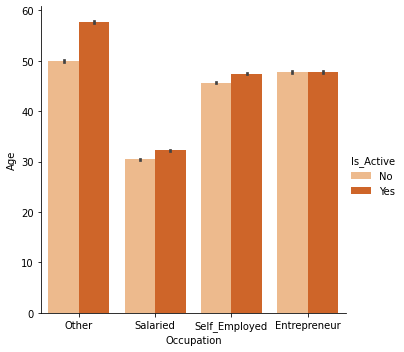

In [60]:
plt.figure(figsize=(8,4))
sns.catplot(y='Age', x='Occupation', hue='Is_Active', data=df, kind='bar', palette='Oranges')
plt.show()

#### FEATURE ENGINEERING

In [61]:
#Mengubah data kategorikal pada kolom "Is_Active" menjadi numerik
df['Is_Active'].replace(['Yes', 'No'], [1,0], inplace=True)
df['Is_Active'] = df['Is_Active'].astype(float)

df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,jenis
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,0.0,0.0,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,0.0,0.0,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,1.0,0.0,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,0.0,0.0,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,0.0,0.0,train


In [62]:
#Ubah semua kolom kategorikal menjadi numerik dengan menggunakan Label Encoder dari library sklearn
cat_to_num = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product']

label_encode = LabelEncoder()
for col in cat_to_num:
  df[col] = label_encode.fit_transform(df[col])

df_2 = df
df_2.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,jenis
0,NNVBBKZB,0,73,18,1,2,43,1,1045696,0.0,0.0,train
1,IDD62UNG,0,30,27,2,0,32,1,581988,0.0,0.0,train
2,HD3DSEMC,0,56,18,3,2,26,1,1484315,1.0,0.0,train
3,BF3NC7KV,1,34,20,2,0,19,1,470454,0.0,0.0,train
4,TEASRWXV,0,30,32,2,0,33,1,886787,0.0,0.0,train


In [63]:
df_train = df_2.loc[df_2['jenis'] == 'train']
df_test = df_2.loc[df_2['jenis'] == 'test']
df_1 = df_train

df_1.drop(columns=['ID', 'jenis'], inplace=True)
df_1.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,18,1,2,43,1,1045696,0.0,0.0
1,0,30,27,2,0,32,1,581988,0.0,0.0
2,0,56,18,3,2,26,1,1484315,1.0,0.0
3,1,34,20,2,0,19,1,470454,0.0,0.0
4,0,30,32,2,0,33,1,886787,0.0,0.0


#### DATA PREPROCESSING

In [64]:
#menghitung kelas mayoritas dan minoritas
df_majority = df_1[df_1['Is_Lead'] == 0]
df_minority = df_1[df_1['Is_Lead'] == 1]

In [65]:
print('Kelas Mayoritas :', len(df_majority))
print('Kelas Minoritas :', len(df_minority))
print('Rasio dari kedua kelas :', len(df_majority)/len(df_minority))

Kelas Mayoritas : 187437
Kelas Minoritas : 58288
Rasio dari kedua kelas : 3.215704776283283


In [66]:
df_majority_undersampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=0)
df_undersampled = pd.concat([df_minority, df_majority_undersampled])

df_undersampled['Is_Lead'].value_counts()
df_1 = df_undersampled

In [67]:
print('Kelas Undersample sebanyak :', len(df_undersampled))
print('Rasio dari kedua kelas :', len(df_undersampled[df_undersampled['Is_Lead']==0])/len(df_undersampled[df_undersampled['Is_Active'] == 1]))

Kelas Undersample sebanyak : 116576
Rasio dari kedua kelas : 1.2114813044291564


In [68]:
#Drop variabel target
xc = df_1.drop(columns=['Is_Lead'])
yc = df_1[['Is_Lead']]

In [69]:
df_1.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,1,62,32,1,2,20,0,1056750,1.0,1.0
15,1,33,18,3,1,69,0,517063,1.0,1.0
16,0,46,18,1,2,97,2,2282502,0.0,1.0
17,0,59,33,1,2,15,2,2384692,0.0,1.0
20,1,44,19,3,1,19,2,1001650,0.0,1.0


In [70]:
#Standarisasi data
sc = StandardScaler()
df_xc = pd.DataFrame(sc.fit_transform(xc), columns=xc.columns)

#### MODELING

In [71]:
#Membuat fungsi untuk menghitung score dari masing-masing model
def max_accuracy_scr(names,model_c,df_xc,yc):
    accuracy_scr_max = 0
    roc_scr_max = 0
    train_xc,test_xc,train_yc,test_yc = train_test_split(df_xc,yc,random_state = 42,test_size = 0.2,stratify = yc)
    model_c.fit(train_xc,train_yc)
    pred = model_c.predict_proba(test_xc)[:, 1]
    roc_score = roc_auc_score(test_yc, pred)
    accuracy_scr = accuracy_score(test_yc,model_c.predict(test_xc))
    if roc_score > roc_scr_max:
      roc_scr_max = roc_score
      final_model = model_c
      mean_acc = cross_val_score(final_model,df_xc,yc,cv=5,scoring="accuracy").mean()
      std_dev = cross_val_score(final_model,df_xc,yc,cv=5,scoring="accuracy").std()
      cross_val = cross_val_score(final_model,df_xc,yc,cv=5,scoring="accuracy")
    print("="*65)
    print("Model : ",names,'\n',
          "Max ROC score sesuai dengan random state " ,roc_scr_max ,'\n',
          "Mean accuracy score :",mean_acc,'\n',
          "Std deviation score :",std_dev,'\n',
          "Cross validation scores :" ,cross_val) 
    print(f"roc_auc_score: {roc_score}")
    print("="*65)

In [72]:
accuracy_scr_max = []
models = []
std_dev = []
roc_auc = []
mean_acc = []
cross_val = []

#Membandingkan 3 model
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier()))

for names,model_c in models:
    max_accuracy_scr(names,model_c,df_xc,yc)

Model :  Logistic Regression 
 Max ROC score sesuai dengan random state  0.727315712597147 
 Mean accuracy score : 0.6696918411779096 
 Std deviation score : 0.0030322593046897828 
 Cross validation scores : [0.67361469 0.66566588 0.66703839 0.67239974 0.66974051]
roc_auc_score: 0.727315712597147
Model :  Random Forest 
 Max ROC score sesuai dengan random state  0.8800927729829505 
 Mean accuracy score : 0.8115735722358428 
 Std deviation score : 0.0014062596662328885 
 Cross validation scores : [0.80910105 0.81007935 0.80995068 0.80926442 0.81569805]
roc_auc_score: 0.8800927729829505
Model :  Decision Tree Classifier 
 Max ROC score sesuai dengan random state  0.7408646423057128 
 Mean accuracy score : 0.742519887786253 
 Std deviation score : 0.002876818684532816 
 Cross validation scores : [0.74558243 0.74093931 0.7405104  0.73875188 0.74655801]
roc_auc_score: 0.7408646423057128


#### EVALUATION

In [73]:
#Melakukan Hyperparameter Tuning
parameters = {"n_estimators":[1,10,100]}
rf_clf = RandomForestClassifier()
clf = GridSearchCV(rf_clf, parameters, cv=5,scoring="roc_auc")
clf.fit(df_xc,yc)
print("Best Parameter : ",clf.best_params_,"\nBest Estimator : ", clf.best_estimator_,"\nBest Score : ", clf.best_score_)

Best Parameter :  {'n_estimators': 100} 
Best Estimator :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
Best Score :  0.8809923926857754


In [74]:
rf_clf = RandomForestClassifier(n_estimators=100,random_state=42)
max_accuracy_scr("RandomForest Classifier",rf_clf,df_xc,yc)

Model :  RandomForest Classifier 
 Max ROC score sesuai dengan random state  0.879415808805665 
 Mean accuracy score : 0.8115392510996895 
 Std deviation score : 0.0008997445291505284 
 Cross validation scores : [0.81180305 0.81136607 0.81106584 0.81037958 0.81308171]
roc_auc_score: 0.879415808805665


In [75]:
xc_train,xc_test,yc_train,yc_test=train_test_split(df_xc, yc,random_state = 80,test_size=0.20,stratify=yc)
rf_clf.fit(xc_train,yc_train)
yc_pred = rf_clf.predict(xc_test)

 ROC_AUC score is  0.8804566893762799
accuracy score is :  0.8127466117687425
Precision is :  0.8397949673811743
Recall is:  0.7729456167438669
F1 Score is :  0.8049848132928354
classification report 
               precision    recall  f1-score   support

         0.0       0.79      0.85      0.82     11658
         1.0       0.84      0.77      0.80     11658

    accuracy                           0.81     23316
   macro avg       0.81      0.81      0.81     23316
weighted avg       0.81      0.81      0.81     23316



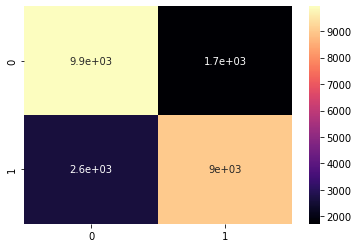

In [76]:
pred_pb=rf_clf.predict_proba(xc_test)[:,1]
Fpr,Tpr,thresholds = roc_curve(yc_test,pred_pb,pos_label=True)
auc = roc_auc_score(yc_test,pred_pb)

print(" ROC_AUC score is ",auc)
print("accuracy score is : ",accuracy_score(yc_test,yc_pred))
print("Precision is : " ,precision_score(yc_test, yc_pred))
print("Recall is: " ,recall_score(yc_test, yc_pred))
print("F1 Score is : " ,f1_score(yc_test, yc_pred))
print("classification report \n",classification_report(yc_test,yc_pred))

#plot confusion matrix
cnf = confusion_matrix(yc_test,yc_pred)
sns.heatmap(cnf, annot=True, cmap = "magma")

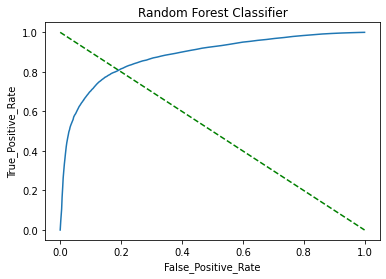

In [77]:
plt.plot([0,1],[1,0],'g--')
plt.plot(Fpr,Tpr)
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.title("Random Forest Classifier")
plt.show()

### LOAD AND PREDICT NEW DATA

In [78]:
df_3 = df_test

In [79]:
df_3.drop(columns=["jenis"],inplace=True)
df_3.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
245725,VBENBARO,1,29,4,1,0,25,2,742366,0.0,NaN
245726,CCMEWNKY,1,43,18,1,1,49,0,925537,0.0,NaN
245727,VK3KGA9M,1,31,20,2,0,14,1,215949,0.0,NaN
245728,TT8RPZVC,1,29,22,1,0,33,1,868070,0.0,NaN
245729,SHQZEYTZ,0,29,20,1,0,19,1,657087,0.0,NaN


In [80]:
xc_pred = df_3.drop(columns=['Is_Lead',"ID"])

#Standarisasi data
sc = StandardScaler()
df_xc_pred = pd.DataFrame(sc.fit_transform(xc_pred),columns=xc_pred.columns)

In [81]:
lead_pred_rf = rf_clf.predict_proba(df_xc_pred)[:,1]
print(lead_pred_rf)

[0.17 0.97 0.09 ... 0.5  0.09 0.15]


In [82]:
lead_pred_rf= pd.DataFrame(lead_pred_rf,columns=["Is_Lead"])

df_test = df_test.reset_index()
df_test.head()

,index,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,245725,VBENBARO,1,29,4,1,0,25,2,742366,0.0,NaN
1,245726,CCMEWNKY,1,43,18,1,1,49,0,925537,0.0,NaN
2,245727,VK3KGA9M,1,31,20,2,0,14,1,215949,0.0,NaN
3,245728,TT8RPZVC,1,29,22,1,0,33,1,868070,0.0,NaN
4,245729,SHQZEYTZ,0,29,20,1,0,19,1,657087,0.0,NaN


In [83]:
df_pred_rf = pd.concat([df_test["ID"],lead_pred_rf],axis=1,ignore_index=True)
df_pred_rf.columns = ["ID","Is_Lead"]
print(df_pred_rf)

              ID  Is_Lead
0       VBENBARO     0.17
1       CCMEWNKY     0.97
2       VK3KGA9M     0.09
3       TT8RPZVC     0.12
4       SHQZEYTZ     0.09
...          ...      ...
105307  DBENJOYI     0.97
105308  CWQ72DWS     0.92
105309  HDESC8GU     0.50
105310  2PW4SFCA     0.09
105311  F2NOYPPZ     0.15

[105312 rows x 2 columns]


In [87]:
#interested, ketika hasil prediksi >= 0.5, sementara not_interested sebaliknya
interested = len(df_pred_rf[df_pred_rf['Is_Lead'] >= 0.5])
not_interested = len(df_pred_rf[df_pred_rf['Is_Lead'] < 0.5])

print("Tertarik :",interested)
print("Tidak Tertarik :",not_interested)

Tertarik : 36063
Tidak Tertarik : 69249


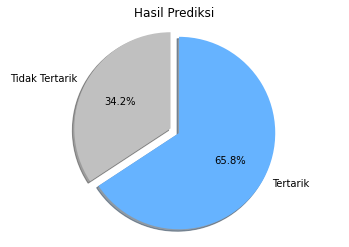

In [85]:
#Melakukan plot pie chart terhadap hasil prediksi customer yang tertarik dan tidak tertarik
my_labels = 'Tidak Tertarik','Tertarik'
data_predict = {'Is_Lead': [interested, not_interested]}
df = pd.DataFrame(data_predict, columns=['Is_Lead'])
my_explode = (0, 0.1)
my_colors = ['silver', '#66b3ff']
plt.pie(df, labels=my_labels,autopct='%1.1f%%', colors=my_colors, startangle=90, shadow = True, explode=my_explode)
plt.title('Hasil Prediksi')
plt.axis('equal')
plt.show()

### KESIMPULAN/SARAN

<h3>Kesimpulan</h3>
<p>Dapat disimpulkan bahwa tidak banyak customer yang tertarik terhadap kartu kredit yang direkomendasikan. Ini terlihat dari beberapa aspek, baik itu Jenis Kelamin (Age), Umur (Age), Jenis Pekerjaan, dll. Dari hasil prediksi terlihat bahwa yang tertarik pada kartu kredit yang direkomendasikan bahkan kurang dari 50% dari keseluruhan jumlah customer</p>

<h3>Saran</h3>
<p>
<ul>
<li>Lebih baik keputusan untuk melakukan cross-selling kartu kredit tidak dilakukan. Dapat ditunda terlebih dahulu atau dapat digantikan dengan cross-selling product yang lain</li>
<li>Jika tetap ingin melakukan cross-selling kartu kredit, maka divisi marketing harus melakukan promosi agar meningkatkan ketertarikan customer terhadap product ini dan setelah itu dilakukan analisa dan prediksi kembali</li>
<li>Untuk meningkatkan keterkaitan antara customer lama dengan product cross-selling, maka customer lama dapat diberi hadiah dan penawaran yang menarik</li>
</ul>
</p>